# Get g distribution for a synthetic transit

Transit modeling with batman https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import photoeccentric as ph
from tqdm import tqdm
import batman
import pandas as pd
import scipy.constants as c

import astropy.units as u
from astropy.timeseries import BoxLeastSquares

from scipy.optimize import curve_fit

import emcee

import PyAstronomy.pyasl as pya

### Functions used in this notebook defined here

In [209]:
#Assuming a circular orbit --

def get_T23(p, rprs, T14, a, i):
    """
    Period: seconds
    rprs: rp in stellar radii
    T14: seconds
    a: semi-major axis in stellar radii
    i: degrees
    
    returs T23: seconds
    """
    
    ing_eg = 4*pya.ingressDuration_Rs(a, rprs, i, p)
    
    T23 = T14-ing_eg
    
    #print('Ingress and egress ', ing_eg)
    #print('T23 ', T23)
    
    return T23

In [3]:
def density(mass, radius, norm=None):
    """Get density of sphere given mass and radius.

    Parameters
    ----------
    mass: float
        Mass of sphere (kg)
    radius: float
        Radius of sphere (m)
    norm: float, default None
        Value to normalize to (kg m^-3)
    """

    if norm==None:
        return ((mass)/((4./3.)*np.pi*radius**3))
    else:
        return ((mass)/((4./3.)*np.pi*radius**3))

In [4]:
def calc_a(period, smass, srad):
    """Calculates semi-major axis from planet period and stellar mass
    Kepler's 3rd law (newton)
    
    Parameters
    ----------
    period: float
        Planet period in DAYS
    smass: float
        Stellar mass in SOLAR MASS
    srad: float
        Stellar radius in SOLAR RADII

    Returns
    -------
    a: float
        Semi-major axis of planet's orbit (normalized to stellar radii)
    """
    
    p_yr = period/365.0

    
    a_cube = (p_yr**2)*smass
    a_au = np.cbrt(a_cube) #a in AU
    a_solr = a_au*215.032 #a in solar radii
    
    a = a_solr/srad #a in stellar radii
    
    return a

In [5]:
def find_density_dist_symmetric(ntargs, masses, masserr, radii, raderr):
    """Gets symmetric stellar density distribution for stars.
    Symmetric stellar density distribution = Gaussian with same sigma on each end.

    Parameters
    ----------
    ntargs: int
        Number of stars to get distribution for
    masses: np.ndarray
        Array of stellar masses (solar mass)
    masserr: np.ndarray
        Array of sigma_mass (solar mass)
    radii: np.ndarray
        Array of stellar radii (solar radii)
    raderr: np.ndarray
        Array of sigma_radius (solar radii)

    Returns
    -------
    rho_dist: np.ndarray
        Array of density distributions for each star in kg/m^3
        Each element length 1000
    mass_dist: np.ndarray
        Array of symmetric Gaussian mass distributions for each star in kg
        Each element length 1000
    rad_dist: np.ndarray
        Array of symmetric Gaussian radius distributions for each star in m
        Each element length 1000
    """

    rho_dist = np.zeros((ntargs, 1000))
    mass_dist = np.zeros((ntargs, 1000))
    rad_dist = np.zeros((ntargs, 1000))

    #star: indexing star
    #point: indexing PDF point for star
    for star in tqdm(range(ntargs)):

        rho_temp = np.zeros(1000)
        mass_temp = np.zeros(1000)
        rad_temp = np.zeros(1000)

        #####
        smass_kg = 1.989E30
        srad_m = 696.34E6
        
        mass_temp = np.random.normal(masses[star]*smass_kg, masserr[star]*smass_kg, 1000)
        #len 1200
        rad_temp = np.random.normal(radii[star]*srad_m, raderr[star]*srad_m, 1000)
        #len 1200
        #####

        #for j from 0 to 1200
        #for each point in individual star PDF
        #Adding each density point to rho_temp (specific to this star)
        for point in range(len(mass_temp)):
            #if mass_dist[point] >= 0. and rad_dist[point] >= 0:
            rho_temp[point] = density(mass_temp[point], rad_temp[point])

        #Now rho_temp is a n-long array with this star. We want it to be 1000-long exactly

        while len(rho_temp) > 1000:
            temp_ind = np.random.randint(0, len(rho_temp)-1)
            rho_temp = np.delete(rho_temp, temp_ind)
            mass_temp = np.delete(mass_temp, temp_ind)
            rad_temp = np.delete(rad_temp, temp_ind)
        else:
            rho_dist[star] = rho_temp
            mass_dist[star] = mass_temp
            rad_dist[star] = rad_temp

    return rho_dist, mass_dist, rad_dist

In [6]:
def get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14, T14err, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    gs = np.zeros((len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = np.random.normal(p, perr, size=1000)
    
    #rs_dist = np.random.normal(rs, rserr, size=1000)
    #rp_earth_dist = np.random.normal(rpearth, rpeartherr, size=1000)
    
    rprs_dist = np.random.normal(rprs, rprserr, size=1000)

    T14_dist = np.random.normal(T14, T14err, size=1000)

    #for j in tqdm(range(len(rhos))): #for element in histogram for star:
    for j in tqdm(range(100)):

        per_dist[j] = per_dist[j]*86400.
        T14_dist[j] = T14_dist[j]*3600.
        
        T23_dist[j] = get_T23(per_dist[j], rprs_dist[j], T14_dist[j], a, i)#Period and T14 need to be in seconds. Then T23 will be in seconds.
        
        rho_circ[j] = ph.get_rho_circ(rprs_dist[j], T14_dist[j], T23_dist[j], per_dist[j])

        g = ph.get_g(rho_circ[j], rhos[j])
        gs[j] = g

        
        
    return gs

In [8]:
def stellar_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    smass: float
        Stellar mass (solar mass)
    srad: float
        Stellar radius (solar radius)
    limbdark_mod: str
        Limb darkening model
    ldm_c1: float
        Limb darkening coefficient 1
    ldm_c2: float
        Limb darkening coefficient 2
    
    """
    smass = float(df.loc[df['kepler_name'] == kep_name].koi_smass) #solar mass
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #solar radius

    limbdark_mod = str(df.loc[df['kepler_name'] == kep_name].koi_limbdark_mod) #LDM Model
    ldm_c2 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff2) #LDM coef 2
    ldm_c1 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff1) #LDM coef 1

    return smass, srad, limbdark_mod, ldm_c1, ldm_c2

In [55]:
def planet_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    period: float
        Orbital period (days)
    rprs: float
        Planet radius (stellar radius)
    a: float
        Semi-major axis (AU)
    e: float
        Eccentricity
    w: float
        Longitude of periastron (degrees)
    i: float
        Inclination (degrees)
    
    """

    period = float(df.loc[df['kepler_name'] == kep_name].koi_period) #solar mass
    rprs = float(df.loc[df['kepler_name'] == kep_name].koi_ror) #solar radius
    
    
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #stellar radius (Sol. rad)
    a_au = float(df.loc[df['kepler_name'] == kep_name].koi_sma) #semi-major axis (AU)
    a_solrad = a_au*215.032 #semi-major axis (Sol. rad)
    
    a = a_solrad/srad

    e = float(df.loc[df['kepler_name'] == kep_name].koi_eccen) #LDM Model
    w = float(df.loc[df['kepler_name'] == kep_name].koi_longp) #LDM coef 2
    i = float(df.loc[df['kepler_name'] == kep_name].koi_incl) #LDM coef 1

    return period, rprs, a, e, w, i

Take stellar parameters from a real star in the sample and put a planet around it.

In [56]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [190]:
kepname = "Kepler-446 b"

smass, srad, _, ldm_c1, ldm_c2 = stellar_params_from_archive(spectplanets, kepname)
period, rprs, a, _, _, i = planet_params_from_archive(spectplanets, kepname)

#a = calc_a(period, smass, srad)

print(smass, srad)
print(period, rprs)
print(a)
print(i)

0.32799999999999996 0.32799999999999996
1.5654126130000001 0.048437
11.931653658536588
89.99


In [191]:
""" Creating mass, masserr, radius, and raderr arrays """

masses = [np.random.normal(smass, 0.05, size=100)]
radii = [np.random.normal(srad, 0.1, size=100)]

###### Find the density of this "star" based on available information (mass and radius)

In [192]:
rho = find_density_dist_symmetric(1, [smass], [0.05], [srad], [0.05])
rho[0].flatten();
rhos = rho[0][0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

100%|██████████| 1/1 [00:00<00:00, 314.25it/s]


In [193]:
np.mean(rhos)

15848.492513541127

##### Create a transit model with planet params above.

In [194]:
time = np.linspace(-24, 24, 8000)

In [195]:
e = 0.0
w = 0.0

In [196]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0                       #eccentricity
    params.w = 100.0                        #longitude of periastron (in degrees)
    params.limb_dark = "linear"        #limb darkening model
    params.u = [0.3]

    #times at which to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [197]:
flux = planetlc(time, period, rprs, a, i)

# Adding gaussian noise
noise = np.random.normal(0,0.0001,len(time))
nflux = flux+noise

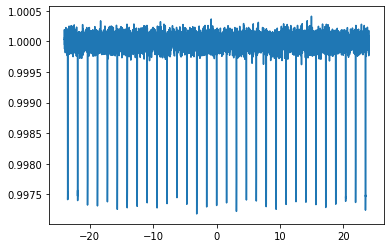

In [198]:
plt.plot(time, nflux)

## Fit transit

#### Astropy BLS

In [199]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

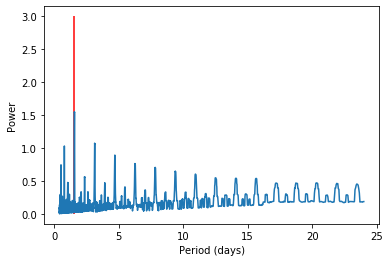

In [200]:
plt.plot(periodogram.period, periodogram.power)
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.vlines(per_guess, 0, 3, color='r')

#### Least-squares using BLS period guess

In [201]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, 0.03, 15, 89.8]
popt, pcov = curve_fit(planetlc, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

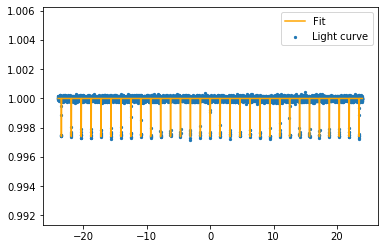

In [202]:
plt.scatter(time, nflux, label='Light curve', s=5)
plt.plot(time, fit, label='Fit', c='orange')
plt.legend()

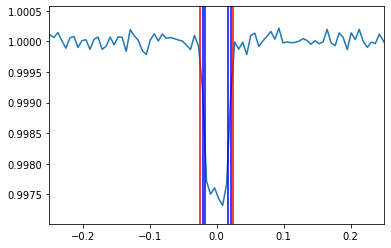

In [203]:
plt.plot(time, nflux)
plt.xlim(-0.25, 0.25)

plt.axvline(-0.025, color='r')
plt.axvline(0.025, color='r')

plt.axvline(-0.025+0.008, color='b')
plt.axvline(0.025-0.008, color='b')

plt.axvline(-0.0416/2, color='b')
plt.axvline(0.0416/2, color='b')

In [204]:
0.0416

0.0416

In [205]:
(0.025-0.008)*2

0.034

In [206]:
p = popt[0] #4.99 days
perr = 0.1

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.01

a = popt[2] #stellar radii

i = popt[3]

T14 = 0.05*24 #hours
T14err = 0.01 #hours

In [210]:
gs_t = get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14, T14err, 100)
gs = gs_t[0:100]

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


In [211]:
gs_sigmaminus, gs_sigmaplus = ph.get_sigmas(gs)

In [212]:
np.mean(gs)

0.6687196033445519

In [213]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

In [214]:
#Guesses
w_guess = 0.0
e_guess = 0.0

In [215]:
solnx = (w_guess, e_guess)

In [216]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [217]:
g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [218]:
g_mean

0.6687196033445519

In [219]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:06<00:00, 727.07it/s]


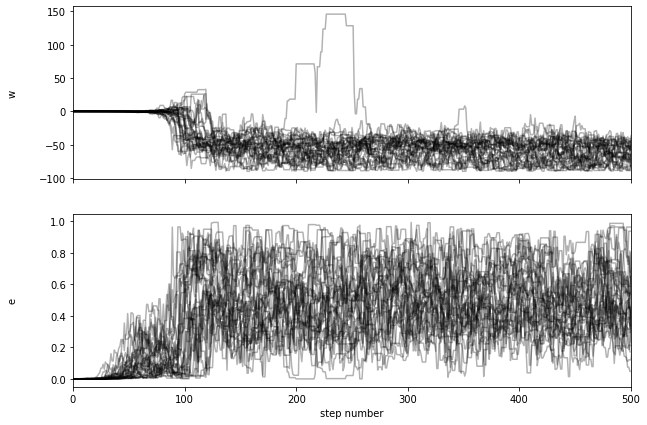

In [220]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [221]:
import corner

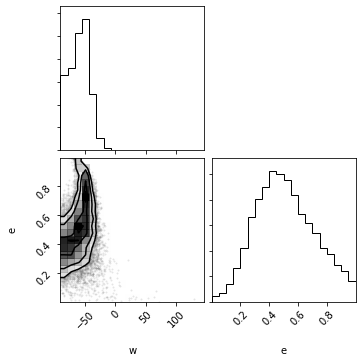

In [222]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)